# Moscow marathon results visualization

## Data loading & discovery

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/all_results.csv', parse_dates=True)

def get_result_time_in_seconds(result_time):
    delta = pd.to_timedelta(result_time)
    if pd.isnull(delta):
        return np.nan
    else:
        return delta.seconds

df['resultTimeSec'] = df['resultTime'].map(get_result_time_in_seconds)

df[['year', 'gender', 'resultTime']].groupby(['year', 'gender']).size()

year  gender
2013  Female     282
      Male      2084
2014  Female     594
      Male      3665
2015  Female    1004
      Male      4902
2016  Female    1293
      Male      6864
dtype: int64

In [3]:
df[ df['resultTimeSec'].isin([df['resultTimeSec'].max(), df['resultTimeSec'].min()]) ]

,year,gender,status,resultTime,genderPosition,country,city,team,resultTimeSec
13824,2016,Male,Finished,2:13:40,1.0,Россия,Уфа,NaN,8020.0
20426,2016,Male,Finished,6:39:09,6603.0,Россия,Москва,Мисцево,23949.0


## Data preparation

In [4]:
import datetime

genders_available = ['Male', 'Female']

def get_result_time_ts(result_time_int):
    return datetime.datetime.fromtimestamp(result_time_int, tz=datetime.timezone.utc)

# Total count of runners
by_year_count_df = {}
for gender in genders_available:
    gender_df = df[ df['gender'] == gender ]
    by_year_count_df[gender] = gender_df.groupby('year').size()
    
years_list = by_year_count_df['Male'].index

# Winner times
winner_result_times_df = df[['year', 'gender', 'resultTimeSec']].groupby(['year', 'gender']).min().reset_index()
by_year_win_times = {}
by_year_win_time_labels = {}
for gender in genders_available:
    gender_win_times_df = winner_result_times_df[ winner_result_times_df['gender'] == gender ]
    by_year_win_times[gender] = gender_win_times_df['resultTimeSec']
    by_year_win_time_labels[gender] = by_year_win_times[gender].map(lambda x: get_result_time_ts(x).strftime('%H:%M:%S'))

# Times of winners
by_year_win_time_labels['Male'].append(by_year_win_time_labels['Female'])

1    02:19:36
3    02:17:23
5    02:19:36
7    02:13:40
0    02:44:52
2    02:40:20
4    02:33:10
6    02:32:34
Name: resultTimeSec, dtype: object

## Visualization

<IPython.core.display.Javascript object>


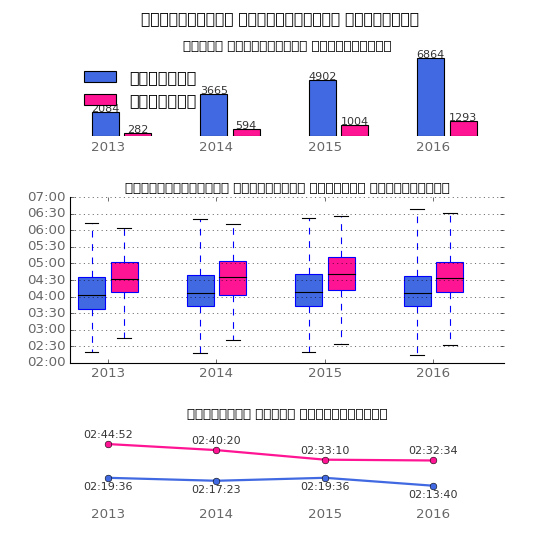

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Common chart settings
font_size_common_title = 14
font_size_subplots_title = 12
labels_text_alpha = 0.6
labels_font_size = 10
label_text_color = 'black'
item_width = .25
item_offset = .15
data_text_alpha = 0.8
winners_time_label_delta = 3 * 60

# Localized texts
localizations_list = {
    'en': {
        'vizualization_header': 'Moscow Marathon Results',
        'participants_header': "Total count of runners (by gender)",
        'available_genders_legend': ['Males', 'Females'],
        'time_distribution_header': "Finish time distribution",
        'winners_header': "Finish time of winners",
    },
    'ru': {
        'vizualization_header': 'Результаты Московского марафона',
        'participants_header': "Общее количество участников",
        'available_genders_legend': ['Мужчины', 'Женщины'],
        'time_distribution_header': "Распределение финишного времени участников",
        'winners_header': "Финишное время победителей",
    },
}
used_localization = localizations_list['ru']


# Color names: http://matplotlib.org/2.0.0b3/examples/color/named_colors.html
data_color_male = 'royalblue'
data_color_female = 'deeppink'

years_index = np.arange(1, len(years_list) + 1)

# Layout settings
fig = plt.figure(figsize=(7, 7), tight_layout=False)

gspec = gridspec.GridSpec(16, 1)
ax_total_count = plt.subplot(gspec[0:3, :])
ax_time_distribution = plt.subplot(gspec[5:11, :], sharex=ax_total_count)
ax_winners = plt.subplot(gspec[13:, :], sharex=ax_total_count)

fig.suptitle(used_localization['vizualization_header'], fontsize=font_size_common_title)

###
# Total runners count
###
ax_total_count.set_title(used_localization['participants_header'], fontsize=font_size_subplots_title)

ax_total_count.set_xticks(years_index)
ax_total_count.set_xticklabels(years_list.values, alpha=labels_text_alpha)

male_count_bars = ax_total_count.bar(years_index - item_offset, height=by_year_count_df['Male'], width=item_width, color=data_color_male)
female_count_bars = ax_total_count.bar(years_index + item_offset, height=by_year_count_df['Female'], width=item_width, color=data_color_female)
for bar in male_count_bars + female_count_bars:
    bar_value = bar.get_height()
    bar_text = str(int(bar_value))
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar_value
    ax_total_count.text(text_x, text_y, bar_text,
                        ha='center', fontsize=labels_font_size, color=label_text_color, alpha=data_text_alpha)

# Legend should be drawn after data renderring
ax_total_count.legend(used_localization['available_genders_legend'], frameon=False, loc=2)

ax_total_count.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
for spine in ax_total_count.spines.values():
    spine.set_visible(False)

###
# Time percentiles
###
ax_time_distribution.set_title(used_localization['time_distribution_header'], fontsize=font_size_subplots_title)

by_years_speed = {'Male': [], 'Female': []}
for year in years_list:
    for gender in ['Male', 'Female']:
        times_df = df[ ~df['resultTimeSec'].isnull() & (df['year'] == year) & (df['gender'] == gender) ]
        by_years_speed[gender].append(times_df['resultTimeSec'])

ax_time_distribution.set_ylim(2 * 60 * 60, 7 * 60 * 60)
time_male_bplot = ax_time_distribution.boxplot(by_years_speed['Male'], whis='range',
                                               widths=item_width, positions=(years_index - item_offset),
                                               patch_artist=True)
time_female_bplot = ax_time_distribution.boxplot(by_years_speed['Female'], whis='range',
                                                 widths=item_width, positions=(years_index + item_offset),
                                                 patch_artist=True)

# Fill boxplots with colors
for bplot, color in ( (time_male_bplot, data_color_male), (time_female_bplot, data_color_female) ):
    for patch in bplot['boxes']:
        patch.set_facecolor(color)
    for patch in bplot['medians']:
        patch.set_color('black')

# Year ticks
ax_time_distribution.set_xticks(years_index)
ax_time_distribution.set_xticklabels(years_list.values, alpha=labels_text_alpha)

# Proper times ticks
time_values = np.arange(2 * 60 * 60, 7 * 60 * 60 + 1, 30 * 60)
time_labels = []
for value in time_values:
    dt = datetime.datetime.fromtimestamp(value, tz=datetime.timezone.utc)
    time_labels.append(dt.strftime('%H:%M'))

# adding horizontal grid lines
ax_time_distribution.yaxis.grid(True)
ax_time_distribution.set_yticks(time_values)
ax_time_distribution.set_yticklabels(time_labels, alpha=labels_text_alpha)

plt.tick_params(top='off', bottom='off', left='on', right='off', labelleft='on', labelbottom='on')
ax_time_distribution.spines['top'].set_visible(False)
ax_time_distribution.spines['right'].set_visible(False)

###
# Winners finish times
###
ax_winners.set_title(used_localization['winners_header'], fontsize=font_size_subplots_title)
ax_winners.set_ylim(2 * 60 * 60, 3 * 60 * 60)

# Year ticks
ax_winners.set_xticks(years_index)
ax_winners.set_xticklabels(years_list.values, alpha=labels_text_alpha)

# Winner time lines
winner_males = ax_winners.plot(years_index, by_year_win_times['Male'], '-o')
plt.setp(winner_males, color=data_color_male, linewidth=2.0)
for x, y, label in zip(years_index, by_year_win_times['Male'], by_year_win_time_labels['Male']):
    ax_winners.annotate(label, xy=(x, y - winners_time_label_delta), xycoords='data',
                        horizontalalignment='center', verticalalignment='top',
                        fontsize=labels_font_size, color=label_text_color, alpha=data_text_alpha)

winner_females = ax_winners.plot(years_index, by_year_win_times['Female'], '-o')
plt.setp(winner_females, color=data_color_female, linewidth=2.0)
for x, y, label in zip(years_index, by_year_win_times['Female'], by_year_win_time_labels['Female']):
    ax_winners.annotate(label, xy=(x, y + winners_time_label_delta), xycoords='data',
                        horizontalalignment='center', verticalalignment='bottom',
                        fontsize=labels_font_size, color=label_text_color, alpha=data_text_alpha)

# Cleanup 
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
for spine in ax_winners.spines.values():
    spine.set_visible(False)
